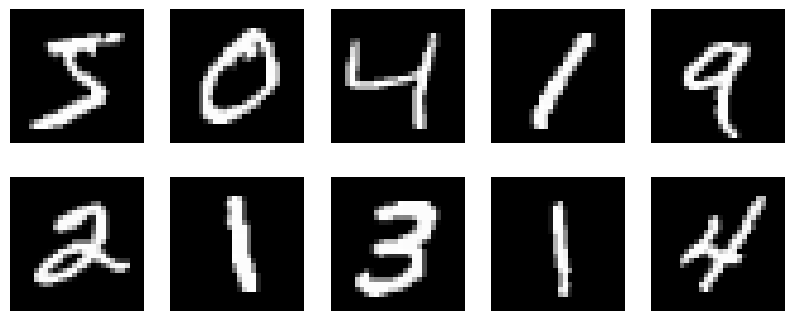

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from src.ppca import ppca_closed_form, mppca, compute_responsibilities, device, compute_probabilities
import torch as th
th.set_grad_enabled(False)
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Reshape the data for visualization (28x28 images)
X_images = X.values.reshape(-1, 28, 28)

# Display the first 10 images from the dataset
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_images[i], cmap='gray')
    plt.axis('off')
plt.show()
X = th.tensor(X.values)

In [2]:
X = X[:5000].float().to(device)  # / 255
# X = X - X.mean(dim=0, keepdim=True)
print(X.shape)

torch.Size([5000, 784])


In [18]:
k = 10
q = 600

W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=q, k=k, max_iter=20)
print(sigma_mppca)

  0%|          | 0/20 [00:00<?, ?it/s]

Finished in 19 iterations with update size 178.20109027535125
tensor([1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06], device='cuda:0',
       dtype=torch.float64)


In [19]:
from pathlib import Path
import time

dir = Path(f"results/mppca/{str(int(time.time()))}-{q}-{k}")
dir.mkdir(parents=True, exist_ok=True)
res = [W_mppca, mu_mppca, sigma_mppca, pi]
res_name = ["W", "mu", "sigma", "pi"]
for r, n in zip(res, res_name):
    th.save(r, dir / f"{n}.pt")

In [32]:
# def load_mppca(dir):
#     if isinstance(dir, str):
#         dir = Path(dir)
#     W = th.load(dir / "W.pt")
#     mu = th.load(dir / "mu.pt")
#     sigma = th.load(dir / "sigma.pt")
#     pi = th.load(dir / "pi.pt")
#     k = pi.shape[0]
#     q = W.shape[2]
#     return W, mu, sigma, pi, k, q
# W_mppca, mu_mppca, sigma_mppca, pi, k, q = load_mppca("results/mppca/2")

C:\Users\Travail\AppData\Local\Temp\ipykernel_18936\2160196306.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  W = th.load(dir / "W.pt")
C:\Users\Travail\AppData\Local\T

In [20]:
from src.ppca import compute_Z, compute_responsibilities
from collections import defaultdict

reconstruction_errors = defaultdict(list)
# Compute the reconstruction of the data :
print(f"MPPCA computed")
d = X.shape[1]
# Start by computing all latent variables: z^m = M^(-1) W^mT (x - mu^m)
Z = compute_Z(W_mppca, X, mu_mppca, sigma_mppca, q, device)  # Z is of shape (M, N, q)
# Then reconstruct the data using x_n = Sum_M Rnm(W^m z_n^m + mu^m)
R = compute_responsibilities(
    X, W_mppca, mu_mppca, sigma_mppca, pi, d, device
)  # R is of shape (M, N)
X_mppca_reconstructed = th.einsum("kdq, knq -> knd", W_mppca, Z) + mu_mppca.unsqueeze(1)
X_mppca_reconstructed = R.unsqueeze(-1) * X_mppca_reconstructed
X_mppca_reconstructed = X_mppca_reconstructed.sum(dim=0)
print(f"MPPCA reconstructed")
# mppca_size = k * (N * q + q * d + d + 1)
# mppca_compression_ratio = mppca_size / original_size
mppca_reconstruction_error = th.mean((X - X_mppca_reconstructed) ** 2).item()

# compression_ratios['MPPCA'].append(mppca_compression_ratio)
reconstruction_errors["MPPCA"].append(mppca_reconstruction_error)
reconstruction_errors

MPPCA computed
MPPCA reconstructed


defaultdict(list, {'MPPCA': [3.0588352648897967e-12]})

In [21]:
from src.ppca import compute_probabilities

probs_density = compute_probabilities(
    X, W_mppca, mu_mppca, sigma_mppca, pi, normalize=False
)

In [22]:
import plotly.express as px

# Create a histogram of the probabilities
fig = px.histogram(
    probs_density.cpu().numpy(),
    nbins=100,
    title="Histogram of Probabilities",
    labels={"value": "Probability"},
)
fig.update_layout(xaxis_title="Probability", yaxis_title="Count")
fig.show()

C:\Users\Travail\AppData\Local\Temp\ipykernel_25820\3754911716.py:2: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



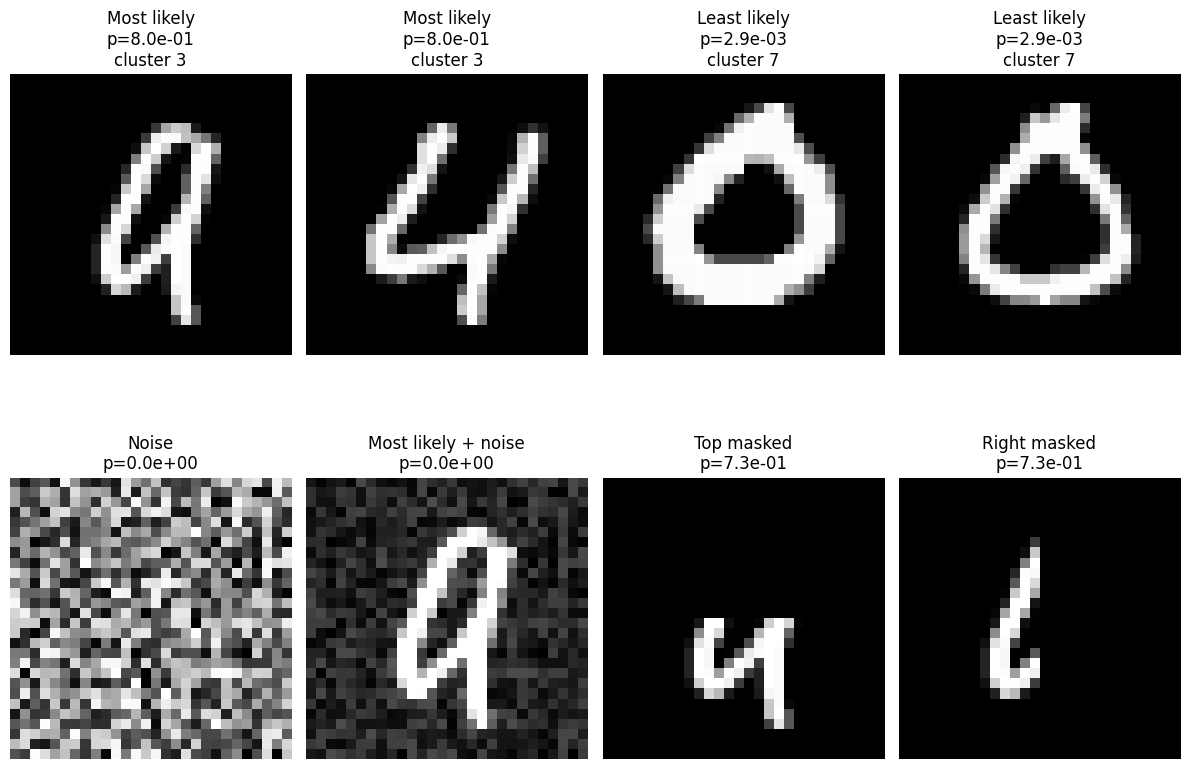

In [99]:
# Get indices of 4 most and least probable digits
most_probable_indices = probs_density.argsort(descending=True)[:4]
least_probable_indices = probs_density.argsort(descending=False)[:4]

# Get cluster assignments
responsibilities = compute_responsibilities(
    X, W_mppca, mu_mppca, sigma_mppca, pi, d=X.shape[1], device=device
)
clusters = responsibilities.argmax(dim=0)

# Create random noise images
noise1 = th.rand((28, 28)).to(device) * 255 * 0.3
noise2 = th.rand((28, 28)).to(device) * 255 * 0.3

# Get most likely digit and add noise
most_likely_idx = most_probable_indices[0]
most_likely_digit = X[most_likely_idx].reshape(28, 28)
noisy_img1 = (most_likely_digit + noise1)
noisy_img2 = (most_likely_digit + noise2)

# get less likely digits
least_likely_idx = least_probable_indices[0]
least_likely_img = X_images[least_likely_idx]

# Create masked versions of most likely digit
masked_top = most_likely_digit.clone()
masked_top[:14, :] = 0
masked_bottom = most_likely_digit.clone()
masked_bottom[14:, :] = 0
masked_left = most_likely_digit.clone()
masked_left[:, :14] = 0
masked_right = most_likely_digit.clone()
masked_right[:, 14:] = 0

# compute the probability of the masked images, noisy images and noise
new_Xs = [
    noise1,
    noise2,
    noisy_img1,
    noisy_img2,
    masked_top,
    masked_bottom,
    masked_left,
    masked_right,
]
new_Xs = th.stack(new_Xs).reshape(len(new_Xs), -1)
probs_new_Xs = compute_probabilities(
    new_Xs, W_mppca, mu_mppca, sigma_mppca, pi, normalize=False
)

# Create figure with 3 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(12, 9))

# Plot 4 most probable digits on first row
for i, idx in enumerate(most_probable_indices[:2]):
    axes[0, i].imshow(clip_image(X_images[idx]), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Most likely\np={probs_density[idx]:.1e}\ncluster {clusters[idx]}")

for i, idx in enumerate(least_probable_indices[:2]):
    axes[0, i + 2].imshow(clip_image(X_images[idx]), cmap="gray")
    axes[0, i + 2].axis("off")
    axes[0, i + 2].set_title(f"Least likely\np={probs_density[idx]:.1e}\ncluster {clusters[idx]}")

# Plot noise and noisy images on second row
axes[1, 0].imshow(clip_image(noise1.cpu()), cmap="gray")
axes[1, 0].axis("off")
axes[1, 0].set_title(f"Noise\np={probs_new_Xs[0]:.1e}")
axes[1, 1].imshow(clip_image(noisy_img1.cpu()), cmap="gray")
axes[1, 1].axis("off")
axes[1, 1].set_title(f"Most likely + noise\np={probs_new_Xs[2]:.1e}")

# Plot masked images on third row
axes[1, 2].imshow(clip_image(masked_top.cpu()), cmap="gray")
axes[1, 2].axis("off")
axes[1, 2].set_title(f"Top masked\np={probs_new_Xs[4]:.1e}")
# axes[2, 1].imshow(clip_image(masked_bottom.cpu()), cmap="gray")
# axes[2, 1].axis("off")
# axes[3, 1].set_title(f"p={probs_new_Xs[5]:.2e}, Bottom masked")
# axes[3, 2].imshow(clip_image(masked_left.cpu()), cmap="gray")
# axes[3, 2].axis("off")
# axes[3, 2].set_title(f"p={probs_new_Xs[6]:.2e}, Left masked")
axes[1, 3].imshow(clip_image(masked_right.cpu()), cmap="gray")
axes[1, 3].axis("off")
axes[1, 3].set_title(f"Right masked\np={probs_new_Xs[7]:.1e}")

plt.tight_layout()
plt.show()

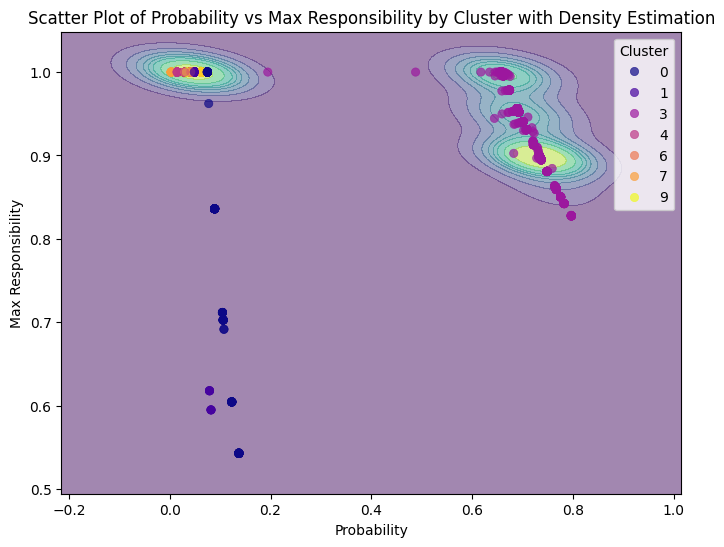

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the maximum responsibility for each point
max_responsibility = responsibilities.max(dim=0).values

# Create a DataFrame for correlation analysis
import pandas as pd

data = pd.DataFrame(
    {
        "Probability": probs_density.cpu().numpy(),
        "Max Responsibility": max_responsibility.cpu().numpy(),
        "Cluster": responsibilities.argmax(dim=0)
        .cpu()
        .numpy(),  # Add cluster information
    }
)

# Plot a scatter plot with color per cluster and add a density estimation
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=data,
    x="Probability",
    y="Max Responsibility",
    fill=True,
    cmap="viridis",
    alpha=0.5,
    thresh=0,
)
sns.scatterplot(
    x="Probability",
    y="Max Responsibility",
    hue="Cluster",
    data=data,
    palette="plasma",
    edgecolor=None,
    alpha=0.7,
)
plt.title(
    "Scatter Plot of Probability vs Max Responsibility by Cluster with Density Estimation"
)
plt.xlabel("Probability")
plt.ylabel("Max Responsibility")
plt.legend(title="Cluster")
plt.show()

In [34]:
# Create a figure with plotly that shows the histogram of probabilities
# with each cluster colored differently
import plotly.graph_objects as go

# Get cluster assignments if not already computed
responsibilities = compute_responsibilities(
    X, W_mppca, mu_mppca, sigma_mppca, pi, d=X.shape[1], device=device
)
clusters = responsibilities.argmax(dim=0)

# Create a separate trace for each cluster
for k in range(len(pi)):
    fig = go.Figure()
    cluster_probs = probs_density[clusters == k].cpu().numpy()
    fig.add_trace(
        go.Histogram(
            x=cluster_probs,
            name=f"Cluster {k}",
            # nbinsx=100,
            opacity=0.7,
            # histnorm='probability',
            bingroup=k,  # Group bars by cluster to avoid overlap
        )
    )

    fig.update_layout(
        title=f"Histogram of Probabilities for cluster {k}",
        xaxis_title="Probability",
        yaxis_title="Count",
        barmode="overlay",
    )
    fig.show()

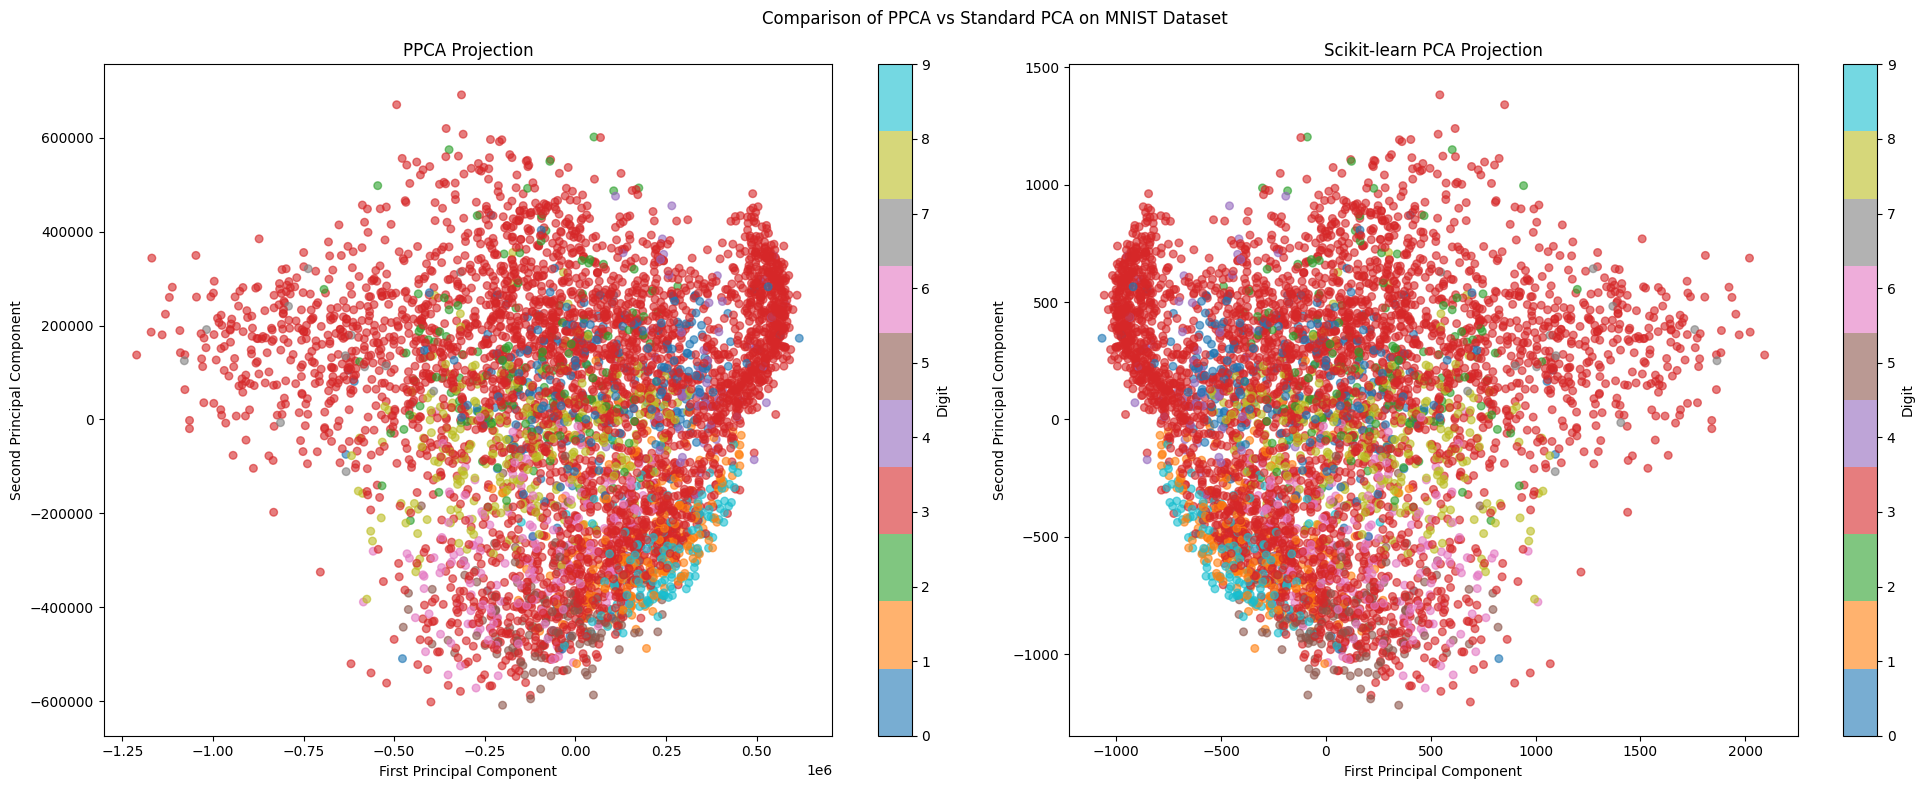

In [39]:
# Compare PPCA with sklearn PCA
from sklearn.decomposition import PCA
from src.ppca import ppca_closed_form

# Compute 2D PPCA projection
q = 2  # Number of principal components for visualization
W_ppca, sigma_ml, mu_ppca = ppca_closed_form(X, q=q)
X_ppca = (X - mu_ppca) @ W_ppca
X_ppca = X_ppca.cpu().numpy()
# Compute sklearn PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.cpu().numpy())

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot PPCA projection
scatter1 = ax1.scatter(
    X_ppca[:, 0], 
    X_ppca[:, 1],
    c=clusters.cpu().numpy(),
    cmap='tab10',
    alpha=0.6,
    s=30
)
ax1.set_title('PPCA Projection')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
fig.colorbar(scatter1, ax=ax1, label='Digit')

# Plot sklearn PCA projection
scatter2 = ax2.scatter(
    X_pca[:, 0], 
    X_pca[:, 1],
    c=clusters.cpu().numpy(),
    cmap='tab10',
    alpha=0.6,
    s=30
)
ax2.set_title('Scikit-learn PCA Projection')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
fig.colorbar(scatter2, ax=ax2, label='Digit')

plt.suptitle('Comparison of PPCA vs Standard PCA on MNIST Dataset')
plt.tight_layout()
plt.show()



In [ ]:
W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=10, k=10, max_iter=30)

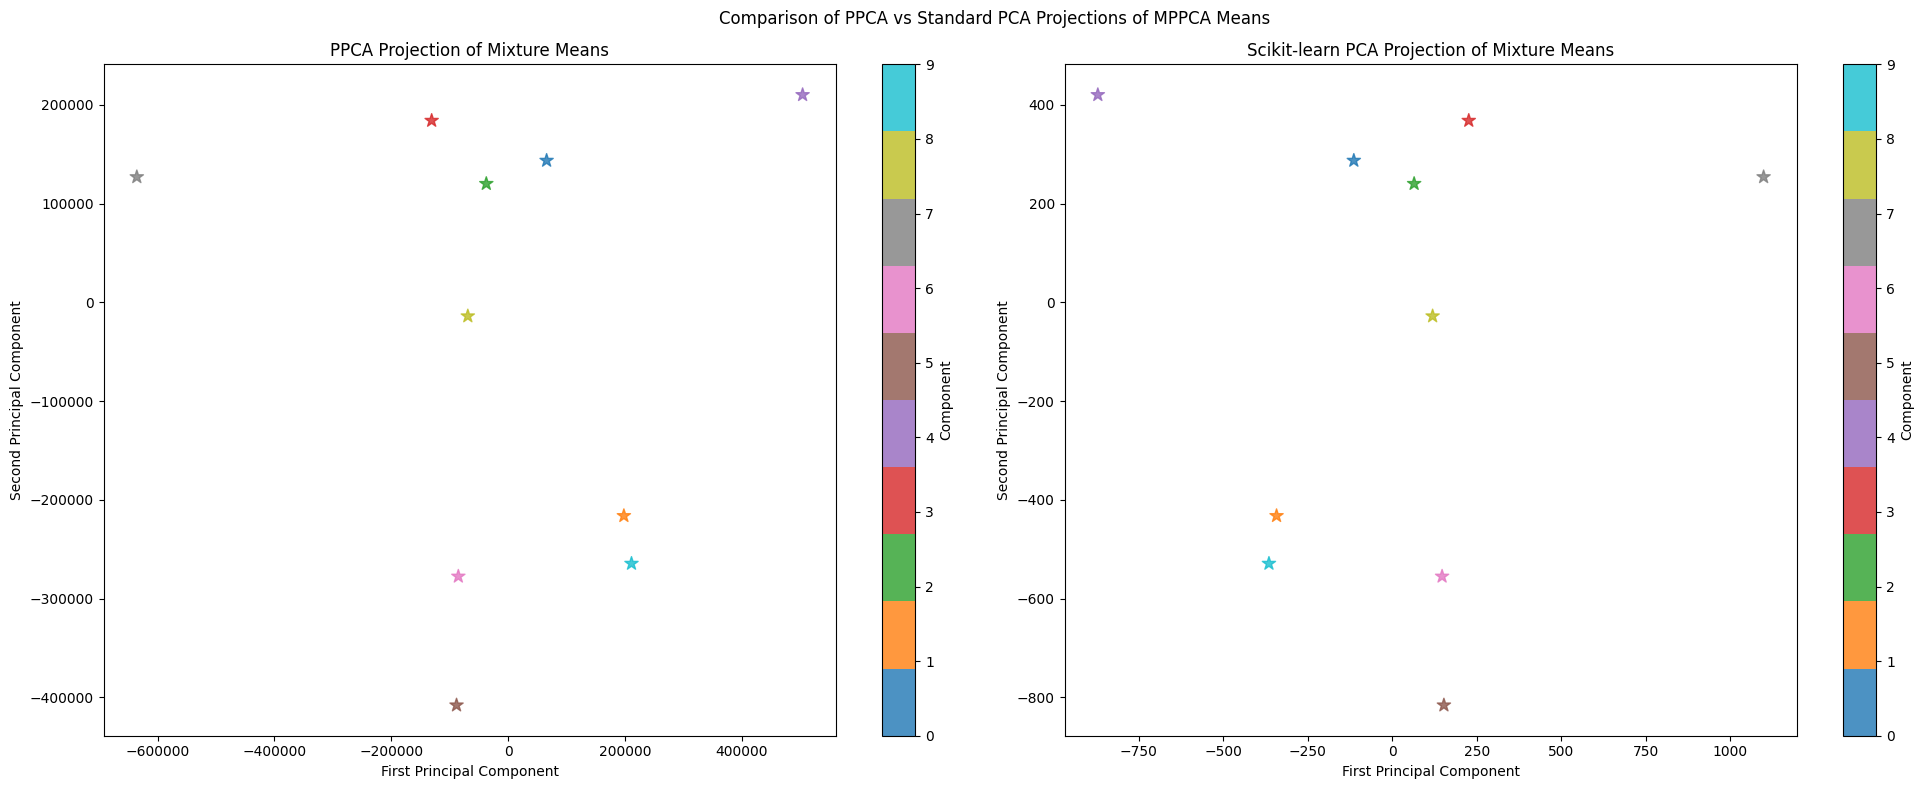

In [43]:
# Convert mu_mppca to numpy for plotting
mu_mppca_np = mu_mppca.cpu().numpy()

# Project mu_mppca using PPCA
mu_ppca_2d = ((mu_mppca.float() - mu_ppca.float()) @ W_ppca.float()).cpu().numpy()
# Project mu_mppca using sklearn PCA
mu_pca_2d = pca.transform(mu_mppca_np)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot PPCA projection of means
scatter1 = ax1.scatter(
    mu_ppca_2d[:, 0],
    mu_ppca_2d[:, 1],
    c=range(len(mu_mppca)),
    cmap='tab10',
    alpha=0.8,
    s=100,
    marker='*'
)
ax1.set_title('PPCA Projection of Mixture Means')
ax1.set_xlabel('First Principal Component') 
ax1.set_ylabel('Second Principal Component')
fig.colorbar(scatter1, ax=ax1, label='Component')

# Plot sklearn PCA projection of means
scatter2 = ax2.scatter(
    mu_pca_2d[:, 0],
    mu_pca_2d[:, 1], 
    c=range(len(mu_mppca)),
    cmap='tab10',
    alpha=0.8,
    s=100,
    marker='*'
)
ax2.set_title('Scikit-learn PCA Projection of Mixture Means')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
fig.colorbar(scatter2, ax=ax2, label='Component')

plt.suptitle('Comparison of PPCA vs Standard PCA Projections of MPPCA Means')
plt.tight_layout()
plt.show()


In [77]:
def clip_image(image):
    return np.maximum(0, np.minimum(255, image))

## Sample from ppca

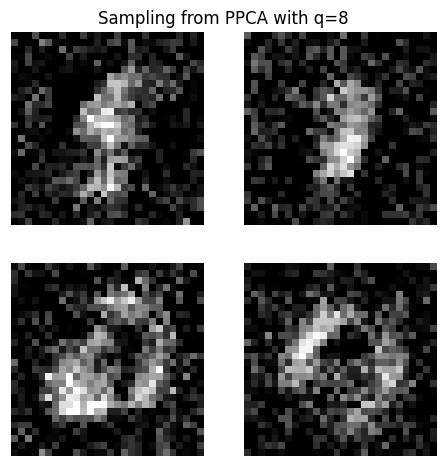

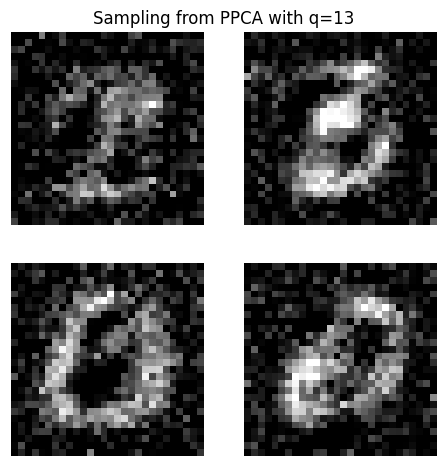

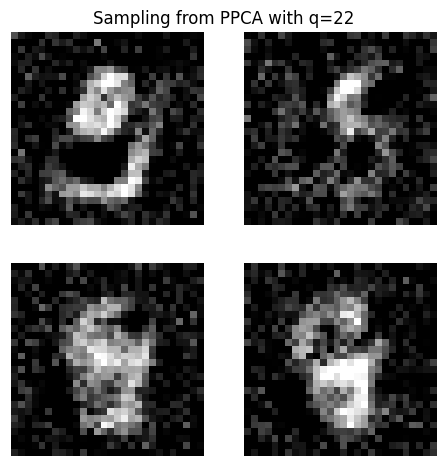

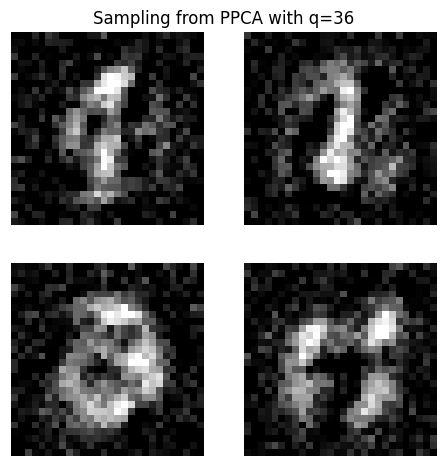

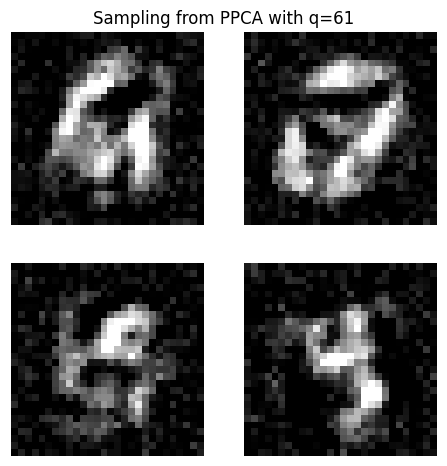

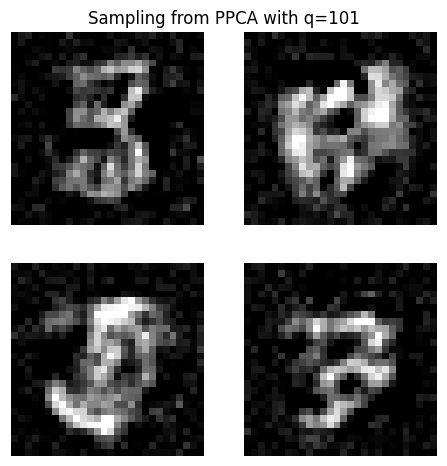

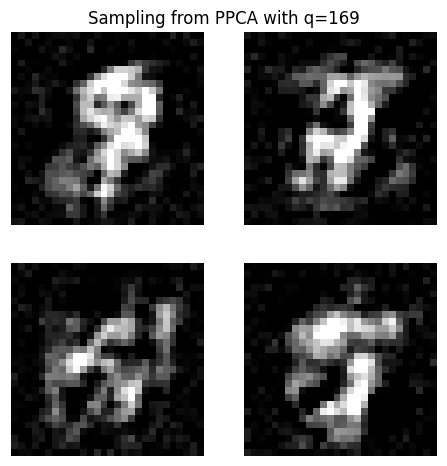

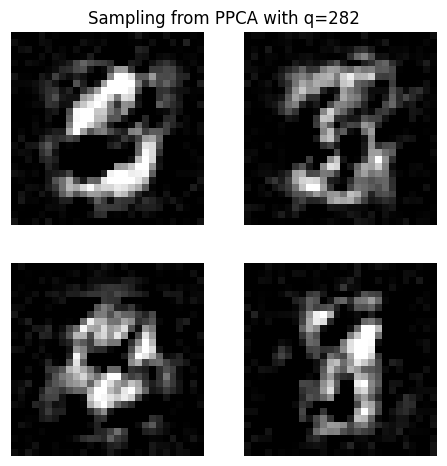

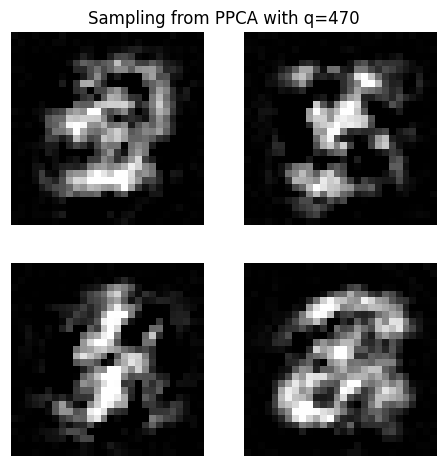

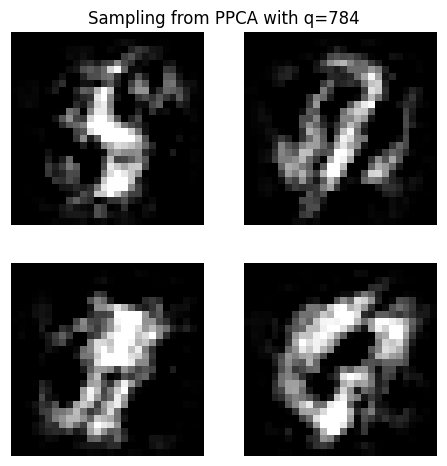

In [78]:
from torch.distributions import MultivariateNormal
def ppc_dist(W, sigma_squared, mu):
    sigma_sample = W @ W.T + sigma_squared * th.eye(W.shape[0]).to(device)
    return MultivariateNormal(mu, sigma_sample)

for q in np.logspace(-2, 0, 10):
    # sample 4 times and plot them
    q = int(X.shape[1] * q + 0.5)
    samples = ppc_dist(*ppca_closed_form(X, q=q)).sample((4,))
    samples = samples.cpu().numpy()
    plt.figure(figsize=(5, 5))
    plt.title(f"Sampling from PPCA with q={q}")
    plt.tight_layout()
    plt.axis('off')
    for i, sample in enumerate(samples):
        plt.subplot(2, 2, i + 1)
        plt.imshow(clip_image(sample.reshape(28, 28)), cmap='gray')
        plt.axis('off')
    plt.show()

## Sample from mppca

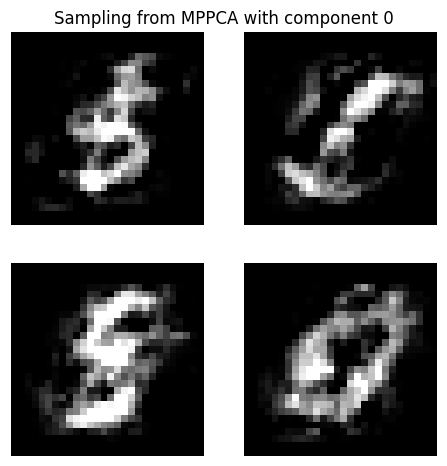

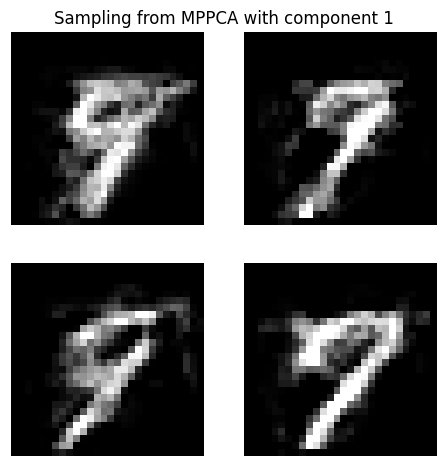

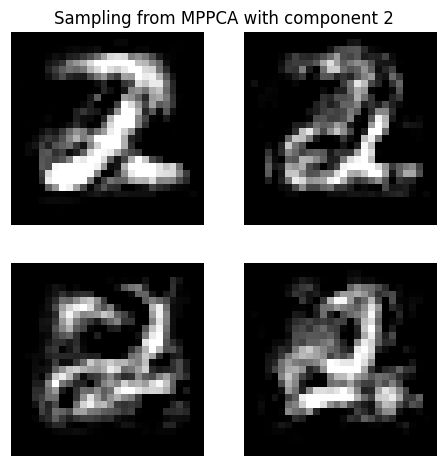

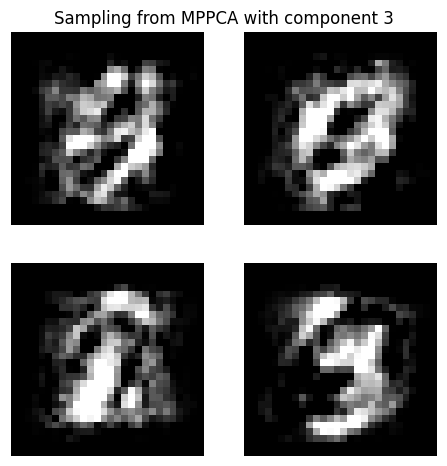

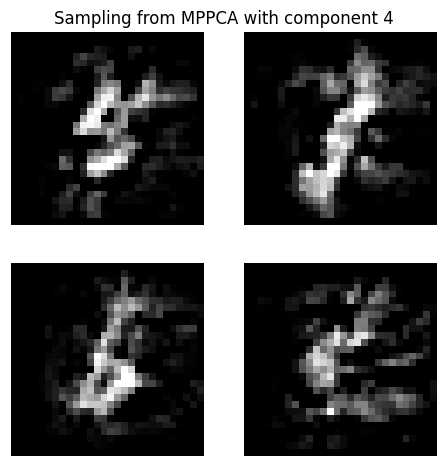

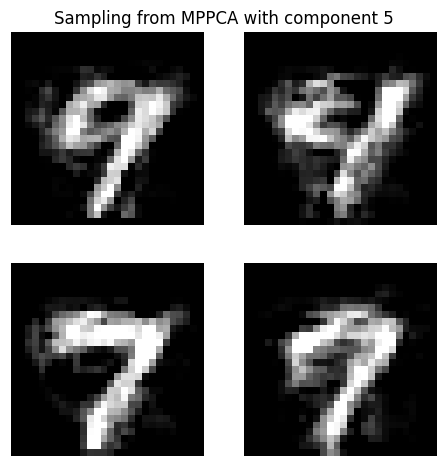

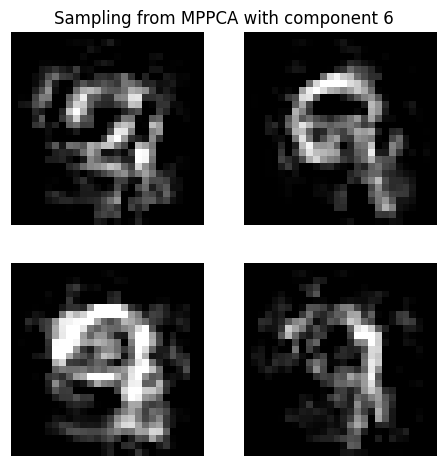

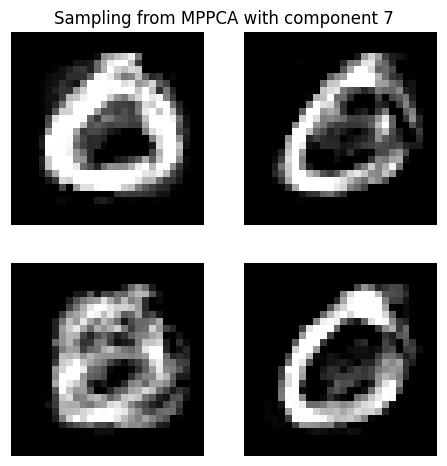

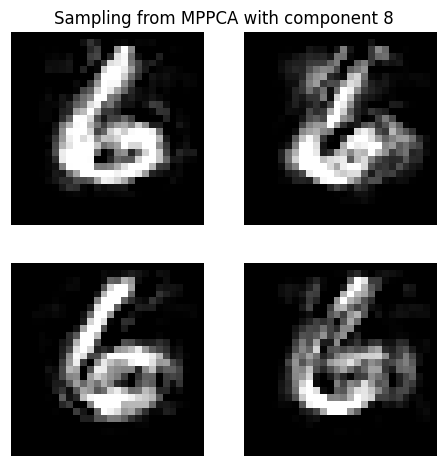

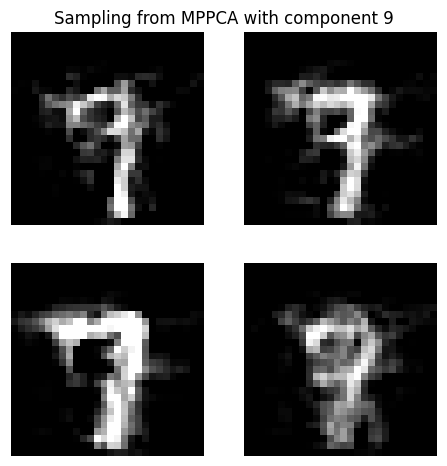

In [79]:
W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=600, k=10, max_iter=30)
for j in range(10):
    samples = ppc_dist(W_mppca[j], sigma_mppca[j], mu_mppca[j]).sample((4,))
    samples = samples.cpu().numpy()
    plt.figure(figsize=(5, 5))
    plt.title(f"Sampling from MPPCA with component {j}")
    plt.tight_layout()
    plt.axis('off')
    for i, sample in enumerate(samples):
        plt.subplot(2, 2, i + 1)
        plt.imshow(clip_image(sample.reshape(28, 28)), cmap='gray')
        plt.axis('off')
    plt.show()

In [87]:
W_mppca.shape

torch.Size([10, 784, 600])

## Figure 6-7

C:\Users\Travail\AppData\Local\Temp\ipykernel_25820\3754911716.py:2: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



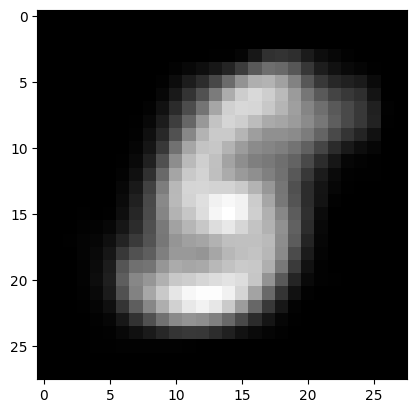

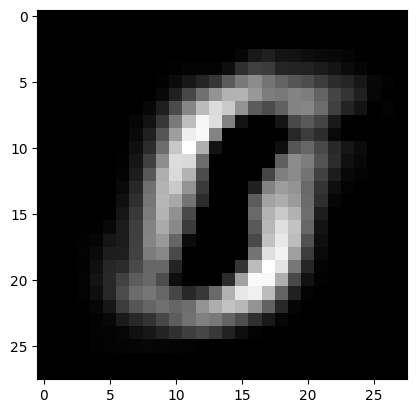

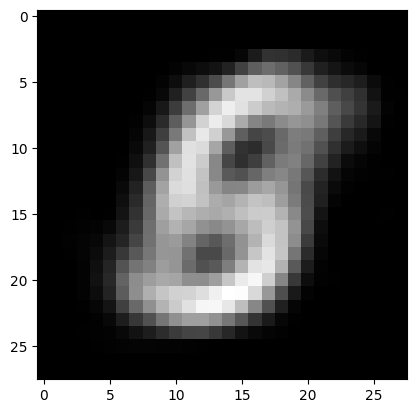

In [88]:
mu_img = mu_mppca[0].reshape(28, 28).cpu()
W_img = W_mppca[0, :, 0].reshape(28, 28).cpu()
plt.imshow(clip_image(mu_img), cmap='gray')
plt.show()
plt.imshow(clip_image(W_img), cmap='gray')
plt.show()
plt.imshow(clip_image(W_img + mu_img), cmap='gray')

C:\Users\Travail\AppData\Local\Temp\ipykernel_25820\3754911716.py:2: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



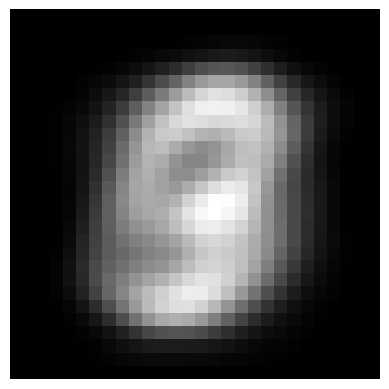

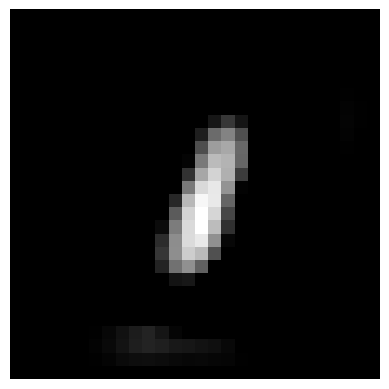

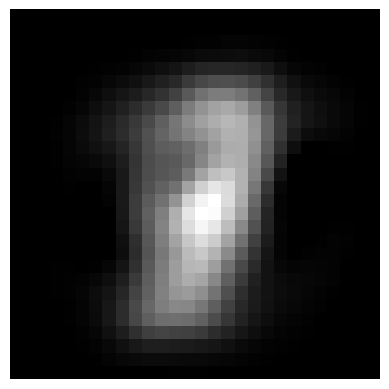

In [92]:
W_ppca, sigma_ppca, mu_ppca = ppca_closed_form(X, q=600)
W_img = W_ppca[:, 0].reshape(28, 28).cpu()
mu_img = mu_ppca.reshape(28, 28).cpu()
plt.imshow(clip_image(mu_img), cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(clip_image(W_img), cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(clip_image(W_img + mu_img), cmap='gray')
plt.axis('off')
plt.show()


# archive

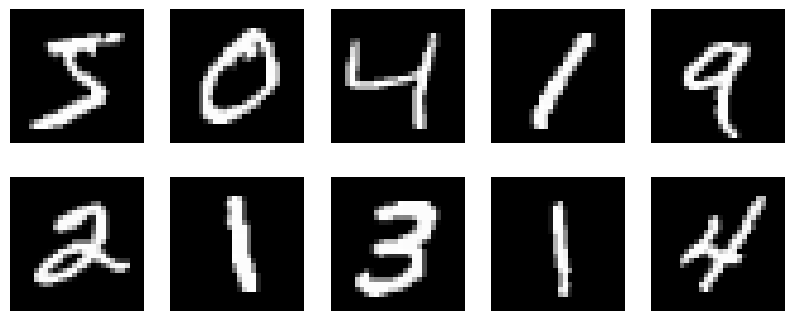

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from src.ppca import ppca_closed_form, mppca


# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Reshape the data for visualization (28x28 images)
X_images = X.values.reshape(-1, 28, 28)

# Display the first 10 images from the dataset
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_images[i], cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
import torch as th
from tqdm.auto import trange
device = "cuda" if th.cuda.is_available() else "cpu"
from src.ppca import ppca_closed_form, mppca

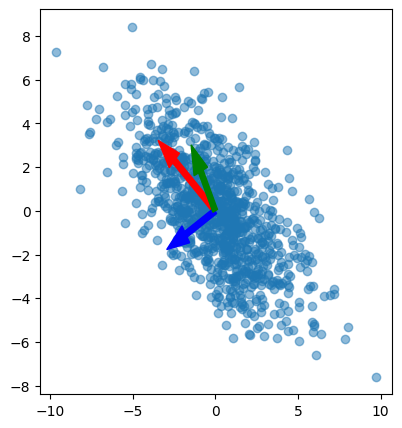

In [ ]:
import torch as th
import numpy as np
from src.ppca import ppca_closed_form, device

def test_ppca_synthetic():
    # Set random seed for reproducibility
    th.manual_seed(42)
    
    # Generate synthetic data
    n_samples = 1000  # number of samples
    d = 10           # observed dimensions
    q = 3            # latent dimensions
    
    # Create true parameters
    W_true = th.randn(d, q).to(device)  # true weight matrix
    z = th.randn(n_samples, q).to(device)  # latent variables
    noise = 0.1 * th.randn(n_samples, d).to(device)  # observation noise
    
    # Generate observations
    X = z @ W_true.T + noise
    
    # Run PPCA
    W_estimated = ppca_closed_form(X, q)
    
    # Since PPCA is invariant to rotations, we need to compare the subspaces
    # rather than the exact matrices
    
    # Compare subspaces using principal angles
    U1 = th.linalg.qr(W_true)[0]
    U2 = th.linalg.qr(W_estimated)[0]
    
   # visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), alpha=0.5, label='Data Points')
    # add principal components
    plt.arrow(0, 0, U2[0, 0].cpu().numpy() * 5, U2[1, 0].cpu().numpy() * 5, color='red', width=0.3)
    plt.arrow(0, 0, U2[0, 1].cpu().numpy() * 5, U2[1, 1].cpu().numpy() * 5, color='blue', width=0.3)
    plt.arrow(0, 0, U2[0, 2].cpu().numpy() * 5, U2[1, 2].cpu().numpy() * 5, color='green', width=0.3)
    plt.show()

test_ppca_synthetic()

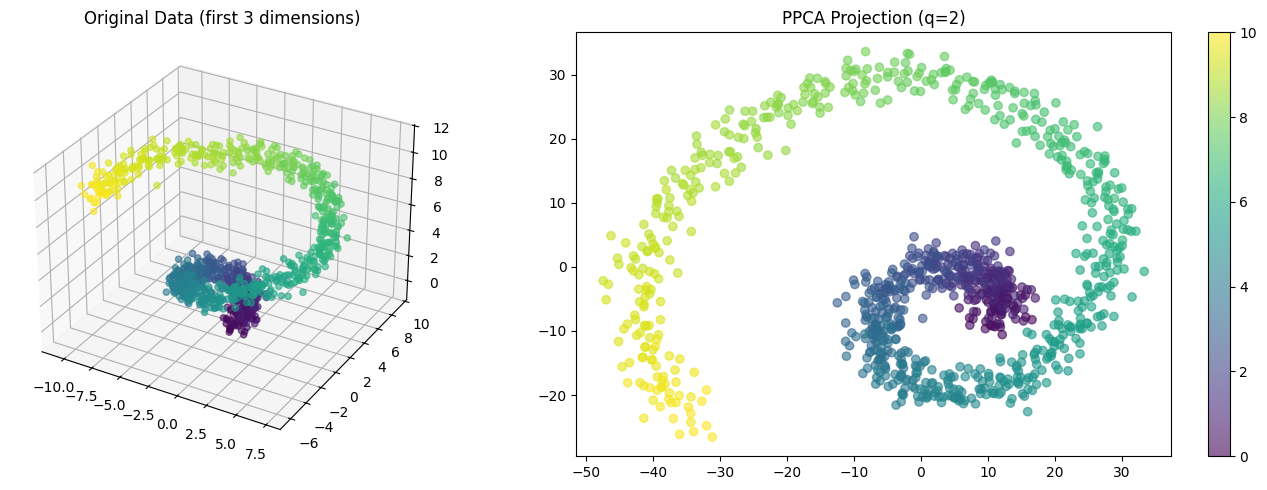

In [ ]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import ppca_closed_form

def visual_test_ppca():
    # Set random seed for reproducibility
    th.manual_seed(42)
    
    # Generate synthetic data with a clear structure
    n_samples = 1000
    
    # Create a 3D spiral
    t = th.linspace(0, 10, n_samples).to(device)
    x = t * th.cos(t).to(device)
    y = t * th.sin(t).to(device)
    z = t.to(device)
    
    # Add some noise
    noise_level = 0.5
    X = th.stack([x, y, z], dim=1) + noise_level * th.randn(n_samples, 3).to(device)
    
    # Add some extra noisy dimensions to make it more interesting
    X = th.cat([X, noise_level * th.randn(n_samples, 2).to(device)], dim=1)
    
    # Run PPCA with q=2
    W = ppca_closed_form(X, q=2)
    
    # Project the data
    X_centered = X - X.mean(dim=0)
    X_projected = X_centered @ W
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Original 3D data
    ax1 = plt.subplot(121, projection='3d')
    ax1.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), X[:, 2].cpu().numpy(), 
                c=t.cpu().numpy(), cmap='viridis', alpha=0.6)
    ax1.set_title('Original Data (first 3 dimensions)')
    
    # PPCA projection
    ax2 = plt.subplot(122)
    scatter = ax2.scatter(X_projected[:, 0].cpu().numpy(), X_projected[:, 1].cpu().numpy(),
                         c=t.cpu().numpy(), cmap='viridis', alpha=0.6)
    ax2.set_title('PPCA Projection (q=2)')
    plt.colorbar(scatter)
    
    plt.tight_layout()
    plt.show()

visual_test_ppca()

  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 8 iterations with update size 5.459342619338533e-05


C:\Users\Travail\AppData\Local\Temp\ipykernel_6936\2287443407.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


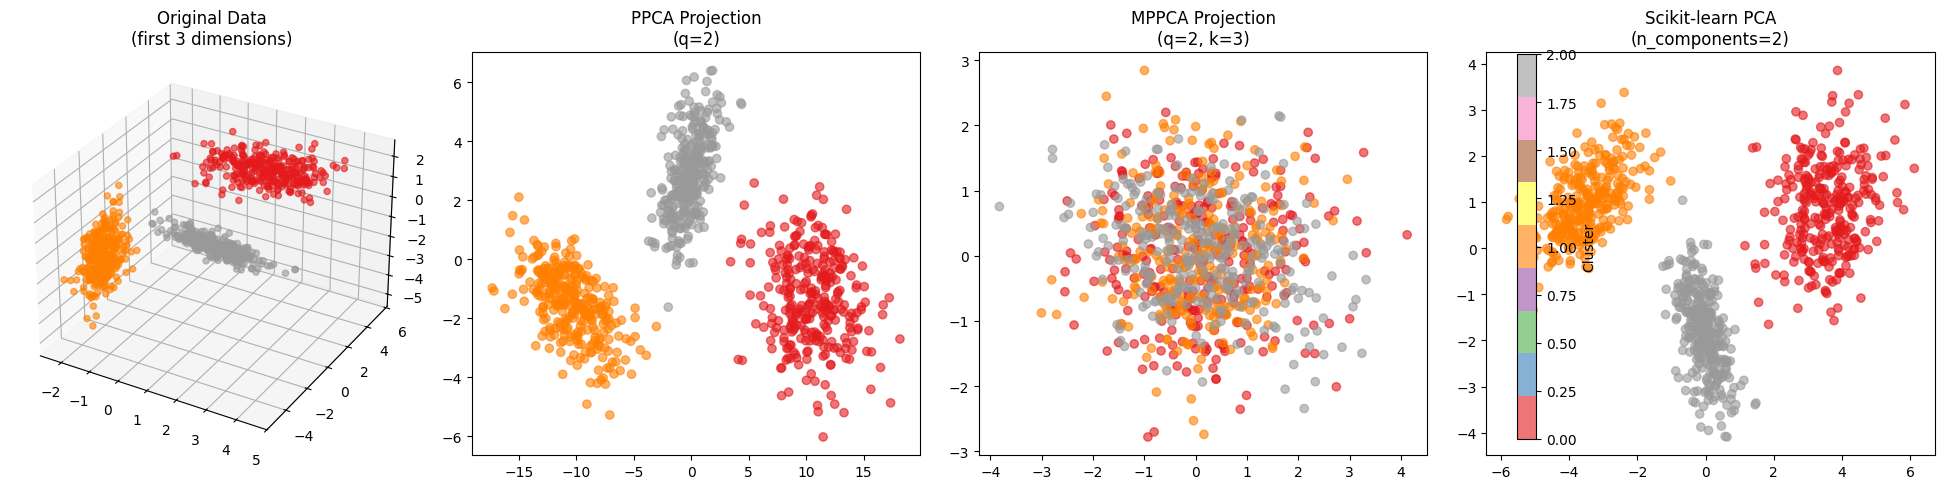

PCA explained variance ratio: [0.73810995 0.2054111 ]


In [ ]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import ppca_closed_form, mppca
from sklearn.decomposition import PCA
device = "cuda" if th.cuda.is_available() else "cpu"
def test_mppca_visual():
    # Set random seed for reproducibility
    th.manual_seed(42)
    np.random.seed(42)
    
    # Generate synthetic data with multiple clusters
    n_samples_per_cluster = 300
    n_clusters = 3
    n_samples = n_samples_per_cluster * n_clusters
    
    # Create clusters in 3D with different orientations
    clusters = []
    colors = []
    
    # Cluster 1: Horizontal plane with some noise
    z1 = th.randn(n_samples_per_cluster, 1).to(device) * 0.1
    xy1 = th.randn(n_samples_per_cluster, 2).to(device) * 1.0
    cluster1 = th.cat([xy1, z1], dim=1) + th.tensor([2.0, 2.0, 2.0]).to(device)
    clusters.append(cluster1)
    colors.extend([0] * n_samples_per_cluster)
    
    # Cluster 2: Vertical plane with some noise
    x2 = th.randn(n_samples_per_cluster, 1).to(device) * 0.1
    yz2 = th.randn(n_samples_per_cluster, 2).to(device) * 1.0
    cluster2 = th.cat([x2, yz2], dim=1) + th.tensor([-2.0, -2.0, -2.0]).to(device)
    clusters.append(cluster2)
    colors.extend([1] * n_samples_per_cluster)
    
    # Cluster 3: Diagonal plane with some noise
    points = th.randn(n_samples_per_cluster, 2).to(device) * 1.0
    noise = th.randn(n_samples_per_cluster, 1).to(device) * 0.1
    rotation = th.tensor([[1.0, -1.0, 1.0], 
                         [1.0, 1.0, -1.0], 
                         [-1.0, 1.0, 1.0]]).to(device) / np.sqrt(3)
    cluster3 = (th.cat([points, noise], dim=1) @ rotation) + th.tensor([2.0, -2.0, 0.0]).to(device)
    clusters.append(cluster3)
    colors.extend([2] * n_samples_per_cluster)
    
    # Combine all clusters
    X = th.cat(clusters, dim=0)
    colors = th.tensor(colors).to(device)
    
    # Add two extra noisy dimensions
    X = th.cat([X, 0.1 * th.randn(n_samples, 2).to(device)], dim=1)
    
    # Run PPCA, MPPCA and PCA
    W_ppca = ppca_closed_form(X, q=2)
    W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=2, k=3)
    pca = PCA(n_components=2)
    
    # Project the data
    X_centered_ppca = X - X.mean(dim=0)
    X_ppca = X_centered_ppca @ W_ppca
    
    # For MPPCA, project using the closest component
    distances = []
    for i in range(3):
        diff = X - mu_mppca[i].unsqueeze(0)
        distances.append(th.sum(diff * diff, dim=1))
    closest_component = th.stack(distances).argmin(dim=0)
    
    X_mppca = th.zeros_like(X_ppca, dtype=th.double)
    for i in range(3):
        mask = (closest_component == i)
        X_centered_mppca = X[mask] - mu_mppca[i].unsqueeze(0)
        X_mppca[mask] = X_centered_mppca @ W_mppca[i]
    
    X_pca = pca.fit_transform(X.cpu().numpy())
    
    # Plotting
    fig = plt.figure(figsize=(20, 5))
    
    # Original 3D data
    ax1 = fig.add_subplot(141, projection='3d')
    scatter1 = ax1.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), X[:, 2].cpu().numpy(), 
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax1.set_title('Original Data\n(first 3 dimensions)')
    
    # PPCA projection
    ax2 = fig.add_subplot(142)
    scatter2 = ax2.scatter(X_ppca[:, 0].cpu().numpy(), X_ppca[:, 1].cpu().numpy(),
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax2.set_title('PPCA Projection\n(q=2)')
    
    # MPPCA projection
    ax3 = fig.add_subplot(143)
    scatter3 = ax3.scatter(X_mppca[:, 0].cpu().numpy(), X_mppca[:, 1].cpu().numpy(),
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax3.set_title('MPPCA Projection\n(q=2, k=3)')
    
    # PCA projection
    ax4 = fig.add_subplot(144)
    scatter4 = ax4.scatter(X_pca[:, 0], X_pca[:, 1],
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax4.set_title('Scikit-learn PCA\n(n_components=2)')
    
    # Add a single colorbar
    plt.colorbar(scatter1, ax=[ax1, ax2, ax3, ax4], label='Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance ratio for PCA
    print("PCA explained variance ratio:", pca.explained_variance_ratio_)

if __name__ == "__main__":
    test_mppca_visual()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 9 iterations with update size 2.732760721654493e-05


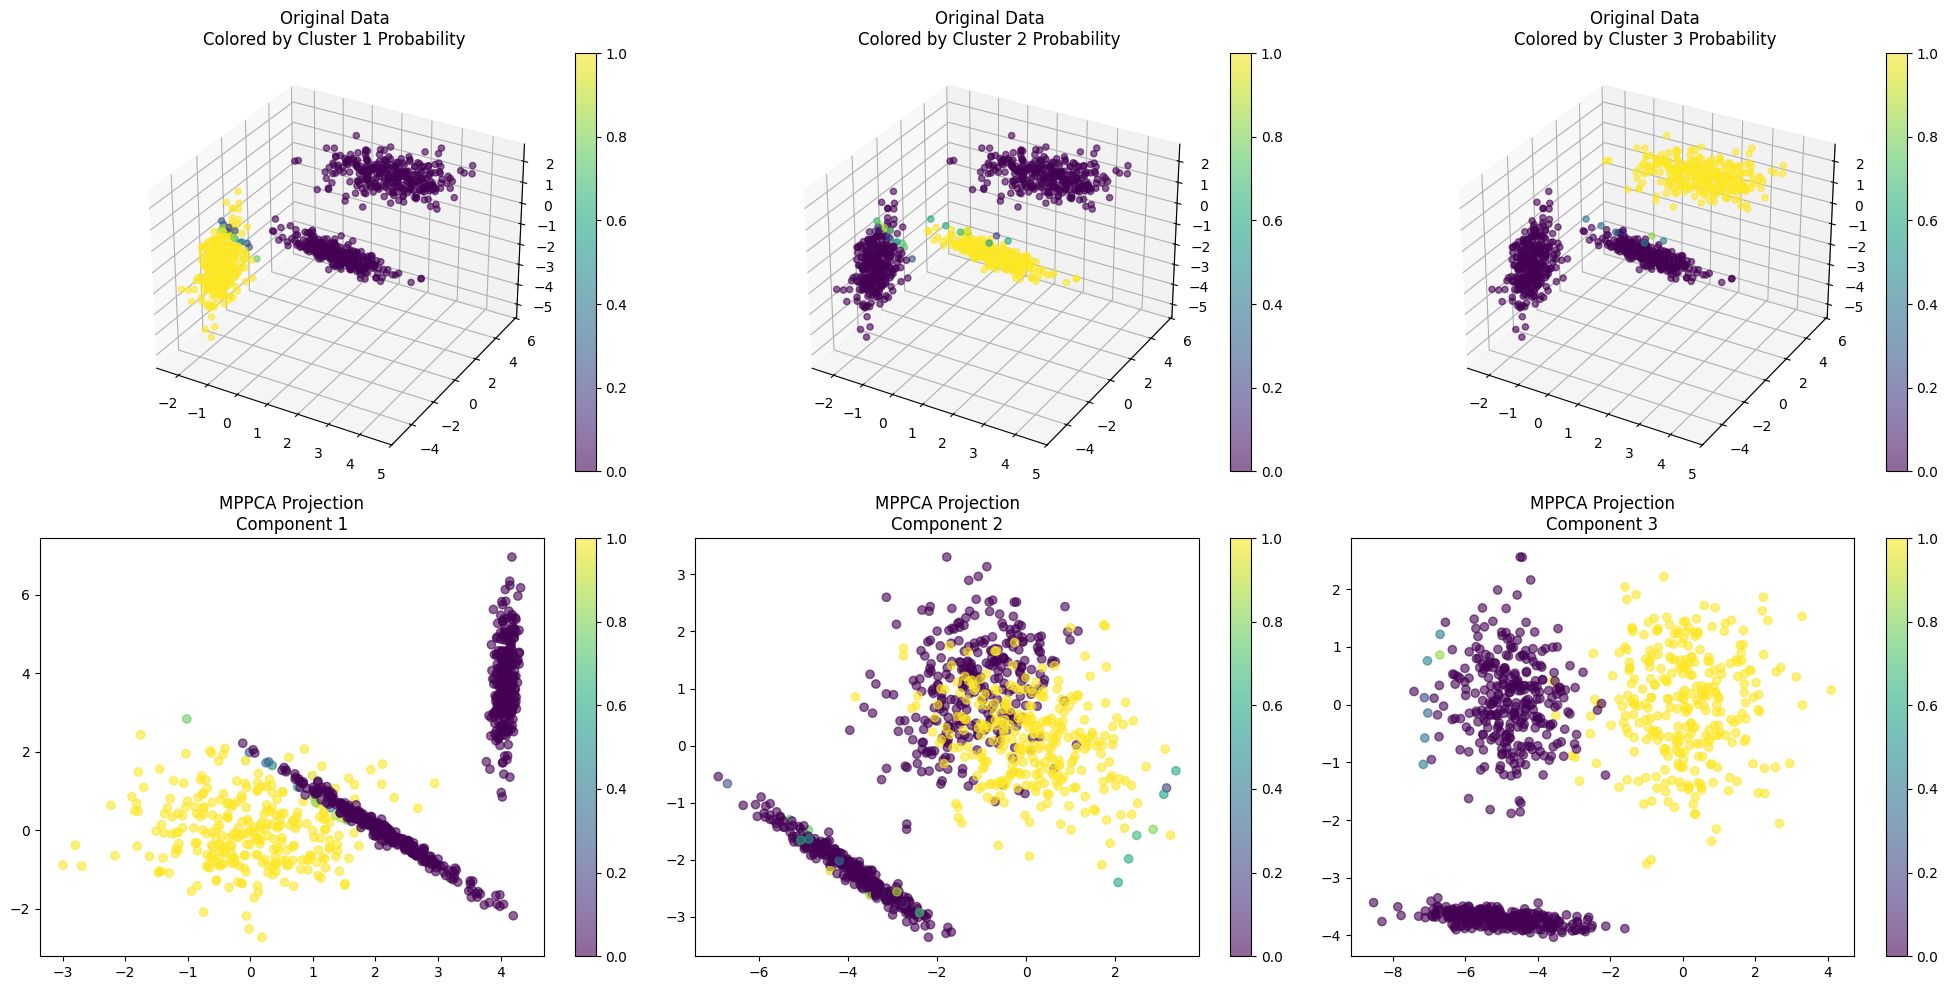

Mixing coefficients: [0.32259283 0.34068257 0.3367246 ]


In [ ]:
%load_ext autoreload
%autoreload 2
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import mppca, compute_Z, compute_responsibilities

device = "cuda" if th.cuda.is_available() else "cpu"

# Set random seed for reproducibility
th.manual_seed(42)
np.random.seed(42)

# Generate synthetic data with multiple clusters
n_samples_per_cluster = 300
n_clusters = 3
n_samples = n_samples_per_cluster * n_clusters

# Create clusters in 3D with different orientations
clusters = []

# Cluster 1: Horizontal plane with some noise
z1 = th.randn(n_samples_per_cluster, 1) * 0.1
xy1 = th.randn(n_samples_per_cluster, 2) * 1.0
cluster1 = th.cat([xy1, z1], dim=1) + th.tensor([2.0, 2.0, 2.0])
clusters.append(cluster1)

# Cluster 2: Vertical plane with some noise
x2 = th.randn(n_samples_per_cluster, 1) * 0.1
yz2 = th.randn(n_samples_per_cluster, 2) * 1.0
cluster2 = th.cat([x2, yz2], dim=1) + th.tensor([-2.0, -2.0, -2.0])
clusters.append(cluster2)

# Cluster 3: Diagonal plane with some noise
points = th.randn(n_samples_per_cluster, 2) * 1.0
noise = th.randn(n_samples_per_cluster, 1) * 0.1
rotation = th.tensor([[1.0, -1.0, 1.0], 
                        [1.0, 1.0, -1.0], 
                        [-1.0, 1.0, 1.0]]) / np.sqrt(3)
cluster3 = (th.cat([points, noise], dim=1) @ rotation) + th.tensor([2.0, -2.0, 0.0])
clusters.append(cluster3)

# Combine all clusters
X = th.cat(clusters, dim=0).to(device)

# Add two extra noisy dimensions
X = th.cat([X, 0.1 * th.randn(n_samples, 2, device=device)], dim=1)

# Run MPPCA
W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=2, k=3)

# Calculate responsibilities using the same code as in mppca implementation
n, d = X.shape
k = W_mppca.shape[0]
Z = compute_Z(W_mppca, X, mu_mppca, sigma_mppca, q, device)
responsibilities = compute_responsibilities(X, W_mppca, mu_mppca, sigma_mppca, pi, d, device)


# Project data for each component
X_mppca = th.zeros(k, n, 2, device=device)
for j in range(k):
    X_centered = X - mu_mppca[j].unsqueeze(0)
    X_mppca[j] = X_centered @ W_mppca[j]

# Plotting
fig = plt.figure(figsize=(20, 10))

# Original 3D data with probabilities for each cluster
for j in range(k):
    # Original data
    ax1 = fig.add_subplot(2, k, j+1, projection='3d')
    scatter1 = ax1.scatter(X.cpu()[:, 0], X.cpu()[:, 1], X.cpu()[:, 2], 
                            c=responsibilities[j].cpu(), 
                            cmap='viridis', alpha=0.6,
                            vmin=0, vmax=1)
    ax1.set_title(f'Original Data\nColored by Cluster {j+1} Probability')
    plt.colorbar(scatter1, ax=ax1)
    
    # MPPCA projection
    ax2 = fig.add_subplot(2, k, j+k+1)
    scatter2 = ax2.scatter(X_mppca[j].cpu()[:, 0], X_mppca[j].cpu()[:, 1],
                            c=responsibilities[j].cpu(),
                            cmap='viridis', alpha=0.6,
                            vmin=0, vmax=1)
    ax2.set_title(f'MPPCA Projection\nComponent {j+1}')
    plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

# Print the mixing coefficients (proportion of points assigned to each cluster)
print("Mixing coefficients:", responsibilities.mean(dim=1).cpu().numpy())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 4 iterations with update size 1.5918804446599536e-05
....................................................................................................

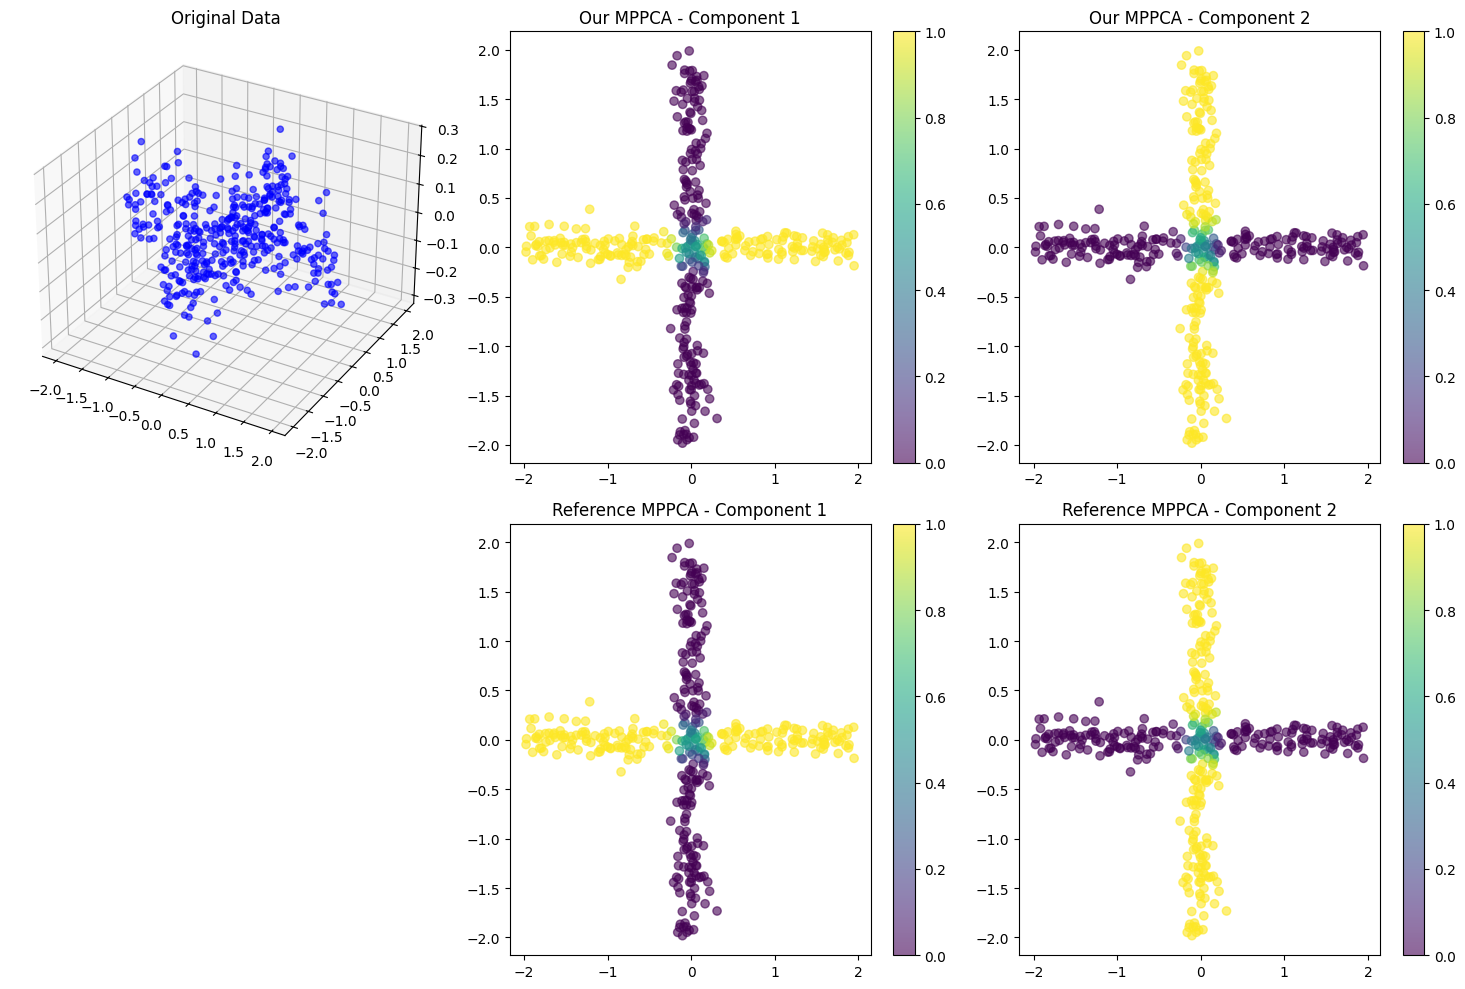

Our MPPCA mixing coefficients: [0.496787 0.503213]
Reference MPPCA mixing coefficients: [0.49704103 0.50295897]


In [ ]:
%load_ext autoreload
%autoreload 2
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import mppca, compute_Z, compute_responsibilities
from ref import initialization_kmeans, mppca_gem

device = "cuda" if th.cuda.is_available() else "cpu"

# Set random seed for reproducibility
th.manual_seed(42)
np.random.seed(42)
q = 1
k = 2
use_kmeans_init = True
# Generate cross-shaped data
n_samples_per_arm = 200
noise = 0.1

# Horizontal arm
x1 = np.random.uniform(-2, 2, n_samples_per_arm)
y1 = np.random.normal(0, noise, n_samples_per_arm)

# Vertical arm
x2 = np.random.normal(0, noise, n_samples_per_arm)
y2 = np.random.uniform(-2, 2, n_samples_per_arm)

# Combine the arms
X_np = np.vstack([
    np.column_stack([x1, y1]),
    np.column_stack([x2, y2])
])

# Add a third noisy dimension
X_np = np.column_stack([X_np, np.random.normal(0, noise, X_np.shape[0])])

# Convert to torch tensor
X = th.tensor(X_np, dtype=th.float32).to(device)

# Run our MPPCA implementation
W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=q, k=k, use_kmeans_init=use_kmeans_init)

# Calculate responsibilities for our implementation
n, d = X.shape
k = W_mppca.shape[0]

M = W_mppca.transpose(1, 2) @ W_mppca + sigma_mppca.unsqueeze(-1).unsqueeze(-1) * th.eye(2, device=device).unsqueeze(0)
M_inv = M.inverse()
Z = compute_Z(W_mppca, X, mu_mppca, sigma_mppca, q, device)

mu_normals = th.einsum("kdq, knq -> knd", W_mppca, Z) + mu_mppca.unsqueeze(1)
sigma_normals = sigma_mppca.unsqueeze(-1).unsqueeze(-1) * th.eye(d, device=device)

# Calculate log responsibilities for numerical stability
responsibilities = compute_responsibilities(X, W_mppca, mu_mppca, sigma_mppca, pi, d, device)

# Run reference implementation
pi_ref, mu_ref, W_ref, sigma2_ref, clusters_ref = initialization_kmeans(X_np, k, q)
pi_ref, mu_ref, W_ref, sigma2_ref, R_ref, L_ref, sigma2hist_ref = mppca_gem(X_np, pi_ref, mu_ref, W_ref, sigma2_ref, 100)

# Plotting
fig = plt.figure(figsize=(15, 10))

# Original data
ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], c='blue', alpha=0.6)
ax1.set_title('Original Data')

# Our MPPCA implementation results
for j in range(k):
    ax = fig.add_subplot(2, 3, j+2)
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], c=responsibilities[j].cpu(),
                        cmap='viridis', alpha=0.6, vmin=0, vmax=1)
    ax.set_title(f'Our MPPCA - Component {j+1}')
    plt.colorbar(scatter, ax=ax)

# Reference implementation results
for j in range(k):
    ax = fig.add_subplot(2, 3, j+5)
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], c=R_ref[:, j],
                        cmap='viridis', alpha=0.6, vmin=0, vmax=1)
    ax.set_title(f'Reference MPPCA - Component {j+1}')
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

# Print comparison of results
print("Our MPPCA mixing coefficients:", responsibilities.mean(dim=1).cpu().numpy())
print("Reference MPPCA mixing coefficients:", pi_ref)

In [ ]:
# Runtime benchmark comparison
import time
import numpy as np
import torch as th
from src.ppca import mppca
from ref import mppca_gem, initialization_kmeans

# Generate high dimensional synthetic data
print("Generating synthetic data...")
n_samples = 10000
n_features = 1000 
q = 10  # Latent dimension
k = 3   # Number of components

# Create structured data with clear clusters
np.random.seed(42)
th.manual_seed(42)

# Generate data from k different distributions
X_list = []
for i in range(k):
    # Create a random projection matrix
    proj = np.random.randn(q, n_features)
    # Generate latent variables
    Z = np.random.randn(n_samples // k, q)
    # Project to high dimensional space and add noise
    X_i = Z @ proj + np.random.randn(n_samples // k, n_features) * 0.1
    X_list.append(X_i)

X_np = np.vstack(X_list)
X = th.tensor(X_np, dtype=th.float32).to(device)

print(f"\nBenchmarking with data shape: {X.shape}")
print(f"Number of components (k): {k}")
print(f"Latent dimension (q): {q}\n")

# Benchmark our implementation
print("Running our MPPCA implementation...")
start_time = time.time()
W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=q, k=k, max_iter=100)
our_time = time.time() - start_time
print(f"Our implementation took: {our_time:.2f} seconds")

# Benchmark reference implementation
print("\nRunning reference MPPCA implementation...")
start_time = time.time()
pi_ref, mu_ref, W_ref, sigma2_ref, clusters_ref = initialization_kmeans(X_np, k, q)
pi_ref, mu_ref, W_ref, sigma2_ref, R_ref, L_ref, sigma2hist_ref = mppca_gem(X_np, pi_ref, mu_ref, W_ref, sigma2_ref, 100)
ref_time = time.time() - start_time
print(f"\nReference implementation took: {ref_time:.2f} seconds")

print(f"\nSpeed ratio (reference/ours): {ref_time/our_time:.2f}x")


Generating synthetic data...

Benchmarking with data shape: torch.Size([9999, 1000])
Number of components (k): 3
Latent dimension (q): 10

Running our MPPCA implementation...


  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 3 iterations with update size 0.0
Our implementation took: 19.38 seconds

Running reference MPPCA implementation...
....................................................................................................
Reference implementation took: 146.39 seconds

Speed ratio (reference/ours): 7.55x


C:\Users\Travail\AppData\Local\Temp\ipykernel_22648\467100542.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


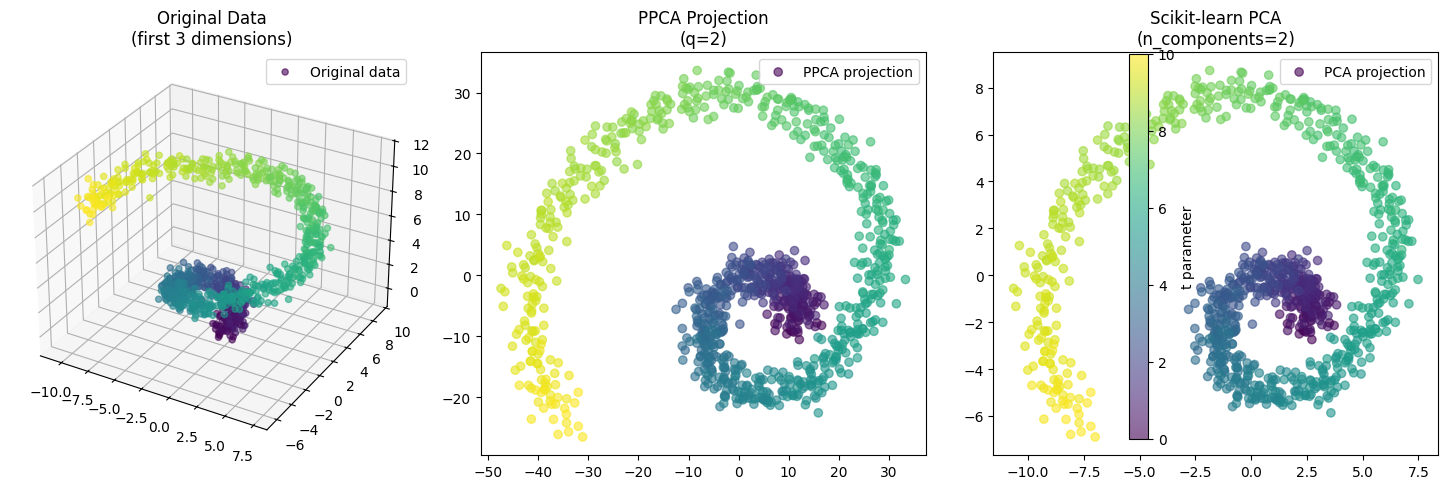

PCA explained variance ratio: [0.47779918 0.357017  ]


In [ ]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import ppca_closed_form
from sklearn.decomposition import PCA

def compare_ppca_pca():
    # Set random seed for reproducibility
    th.manual_seed(42)
    np.random.seed(42)
    
    # Generate synthetic data with a clear structure
    n_samples = 1000
    
    # Create a 3D spiral
    t = th.linspace(0, 10, n_samples).to(device)
    x = t * th.cos(t).to(device)
    y = t * th.sin(t).to(device)
    z = t.to(device)
    
    # Add some noise
    noise_level = 0.5
    X = th.stack([x, y, z], dim=1) + noise_level * th.randn(n_samples, 3).to(device)
    
    # Add some extra noisy dimensions
    X = th.cat([X, noise_level * th.randn(n_samples, 2).to(device)], dim=1)
    
    # Run PPCA with q=2
    W = ppca_closed_form(X, q=2)
    
    # Project the data using PPCA
    X_centered = X - X.mean(dim=0)
    X_ppca = X_centered @ W
    
    # Run sklearn PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.cpu().numpy())
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Original 3D data
    ax1 = plt.subplot(131, projection='3d')
    scatter1 = ax1.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), X[:, 2].cpu().numpy(), 
                          c=t.cpu().numpy(), cmap='viridis', alpha=0.6,
                          label='Original data')
    ax1.set_title('Original Data\n(first 3 dimensions)')
    ax1.legend()
    
    # PPCA projection
    ax2 = plt.subplot(132)
    scatter2 = ax2.scatter(X_ppca[:, 0].cpu().numpy(), X_ppca[:, 1].cpu().numpy(),
                          c=t.cpu().numpy(), cmap='viridis', alpha=0.6,
                          label='PPCA projection')
    ax2.set_title('PPCA Projection\n(q=2)')
    ax2.legend()
    
    # PCA projection
    ax3 = plt.subplot(133)
    scatter3 = ax3.scatter(X_pca[:, 0], X_pca[:, 1],
                          c=t.cpu().numpy(), cmap='viridis', alpha=0.6,
                          label='PCA projection')
    ax3.set_title('Scikit-learn PCA\n(n_components=2)')
    ax3.legend()
    
    # Add colorbar
    plt.colorbar(scatter1, ax=[ax1, ax2, ax3], label='t parameter')
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance ratio for PCA
    print("PCA explained variance ratio:", pca.explained_variance_ratio_)

compare_ppca_pca()

## Test ppca

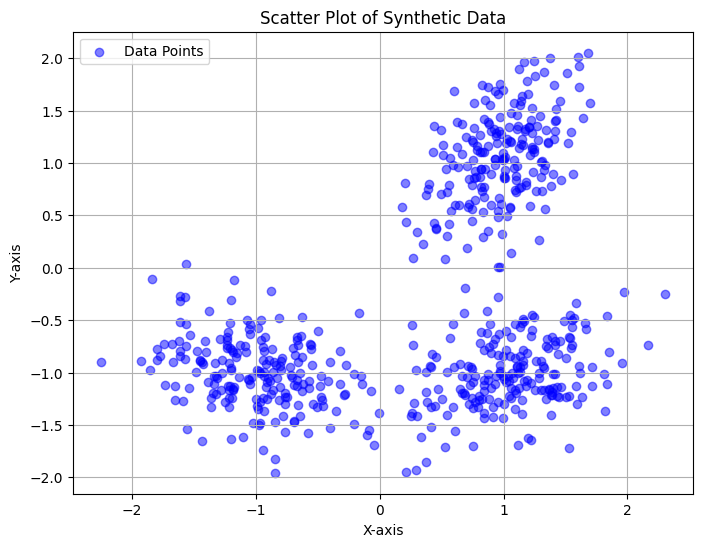

  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 99 iterations with update size 9.857628311783277e-06


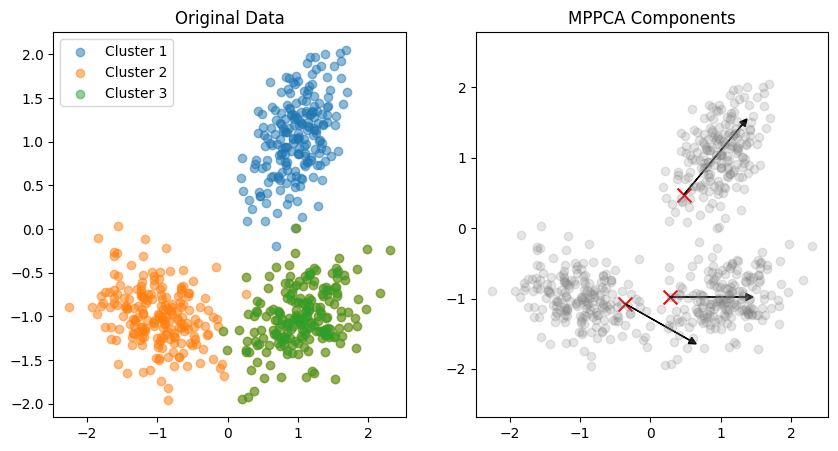

In [ ]:
# synthetic data experiment in 2d
import torch as th
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
th.manual_seed(42)

# Generate synthetic data from 2 Gaussians
n_samples = 200
n_components = 2

# First Gaussian centered at (1,1) with some covariance
mean1 = th.tensor([1.0, 1.0])
cov1 = th.tensor([[0.1, 0.05], [0.05, 0.2]])
samples1 = th.distributions.MultivariateNormal(mean1, cov1).sample((n_samples,))

# Second Gaussian centered at (-1,-1) with different covariance
mean2 = th.tensor([-1.0, -1.0]) 
cov2 = th.tensor([[0.2, -0.05], [-0.05, 0.1]])
samples2 = th.distributions.MultivariateNormal(mean2, cov2).sample((n_samples,))

# third gaussian
mean3 = th.tensor([1.0, -1.0])
cov3 = th.tensor([[0.2, 0.05], [0.05, 0.1]])
samples3 = th.distributions.MultivariateNormal(mean3, cov3).sample((n_samples,))

# Combine the samples
X = th.cat([samples1, samples2, samples3], dim=0)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, c='blue', label='Data Points')
plt.title('Scatter Plot of Synthetic Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

# Initialize MPPCA parameters
k = 3  # number of components
d = 2  # data dimension
q = 1  # latent dimension
device = X.device

# Random initialization
W = th.randn(k, d, q).to(device)
mu = th.randn(k, d).to(device)
sigma = th.ones(k).to(device)
pi = th.ones(k).to(device) / k

# Fit MPPCA
W, mu, sigma, pi = mppca(X, q, k, max_iter=100, epsilon=1e-6)

# Visualize results
plt.figure(figsize=(10, 5))

# Plot original data
plt.subplot(121)
plt.scatter(X[:n_samples,0].cpu().numpy(), X[:n_samples,1].cpu().numpy(), alpha=0.5, label='Cluster 1')
plt.scatter(X[n_samples:,0].cpu().numpy(), X[n_samples:,1].cpu().numpy(), alpha=0.5, label='Cluster 2')
plt.scatter(X[2*n_samples:,0].cpu().numpy(), X[2*n_samples:,1].cpu().numpy(), alpha=0.5, label='Cluster 3')
plt.title('Original Data')
plt.legend()

# Plot principal components
plt.subplot(122)
for i in range(k):
    plt.scatter(mu[i,0].cpu().numpy(), mu[i,1].cpu().numpy(), c='red', marker='x', s=100)
    # Plot the principal direction
    direction = W[i,:,0]
    plt.arrow(mu[i,0].cpu().numpy(), mu[i,1].cpu().numpy(), direction[0].cpu().numpy(), direction[1].cpu().numpy(), 
             head_width=0.1, head_length=0.1, fc='k', ec='k')

plt.scatter(X[:,0], X[:,1], alpha=0.2, c='gray')
plt.title('MPPCA Components')
plt.axis('equal')
plt.show()


## Denoising using mppca

torch.Size([1, 1, 600]) torch.Size([1, 784, 600]) torch.Size([1, 784])


C:\Users\Travail\AppData\Local\Temp\ipykernel_25820\3754911716.py:2: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



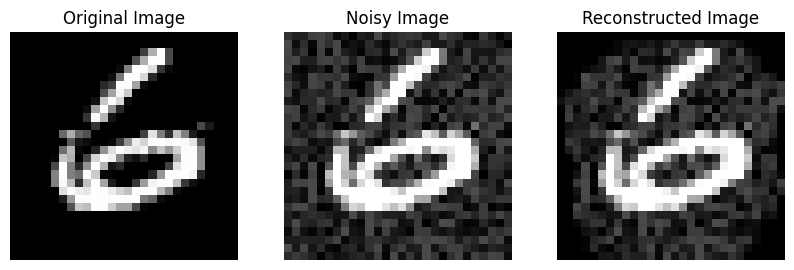

In [84]:
x_sample = X[np.random.randint(0, X.shape[0])]
noise = th.rand_like(x_sample) * 255 * 0.3
x_noisy = x_sample + noise
q = 600
# compute ppca
W_ppca, sigma_ml, mu_ppca = ppca_closed_form(X, q=q)
W_ppca, x_noisy, sigma_ml, mu_ppca = W_ppca.unsqueeze(0), x_noisy.unsqueeze(0), sigma_ml.unsqueeze(0), mu_ppca.unsqueeze(0)
# x_ppca = (x_noisy - mu_ppca) @ W_ppca
Z = compute_Z(W_ppca, x_noisy, mu_ppca, sigma_ml, q=q, device=device) # Z is of shape (M, N, q)
print(Z.shape, W_ppca.shape, mu_ppca.shape)
x_reconstructed = th.einsum("kdq, knq -> knd", W_ppca, Z) + mu_ppca.unsqueeze(1) # X_ppca_reconstructed is of shape (M, N, d)
x_reconstructed = x_reconstructed.squeeze(0) # X_ppca_reconstructed is of shape (N, d)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(clip_image(x_sample.reshape(28, 28).cpu()), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(clip_image(x_noisy.reshape(28, 28).cpu()), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(clip_image(x_reconstructed.reshape(28, 28).cpu()), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

## Gregoire

In [85]:
x_sample = X[np.random.randint(0, X.shape[0])]
noise = th.rand_like(x_sample) * 255 * 0.3
x_noisy = x_sample + noise
q = 600
# compute ppca
W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=q, k=10, max_iter=30)
# x_ppca = (x_noisy - mu_ppca) @ W_ppca
Z = compute_Z(W_mppca, x_noisy.unsqueeze(0), mu_mppca, sigma_mppca, q, device) # Z is of shape (M, N, q)
# Then reconstruct the data using x_n = Sum_M Rnm(W^m z_n^m + mu^m)
R = compute_responsibilities(X, W_mppca, mu_mppca, sigma_mppca, pi, d, device) # R is of shape (M, N)
X_mppca_reconstructed = (th.einsum("kdq, knq -> knd", W_mppca, Z) + mu_mppca.unsqueeze(1))
X_mppca_reconstructed = R.unsqueeze(-1) * X_mppca_reconstructed
X_mppca_reconstructed = X_mppca_reconstructed.sum(dim=0)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(clip_image(x_sample.reshape(28, 28).cpu()), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(clip_image(x_noisy.reshape(28, 28).cpu()), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(clip_image(x_reconstructed.reshape(28, 28).cpu()), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

Finished in 29 iterations with update size 15422.003261130198


NameError: name 'X_th' is not defined